# STOCK/CRPYTO PRICE PREDICTION MODEL

## The following code is an example on how to use simple data analysis tolls in order to set up a simple strategy for long and short term financial trading

### We will make use of the programing language python (3.x) which suits nicely for data anlysis

## --> This a very is simplified model for trading. One should always invest just as much money as one can afford to loose and do own studies in advance. 

## Required modules:
- numpy: the code is designed to be vectorized such that the numpy module can be used and calculations performed fast
- pandas: module for illustrative data frames
- yfinance: api module provided by yahoo finance to get current and previous asset prices
- matplotlib: (sub)module(s) for plots
- scipy: (sub)module for statistical and signal analysis
- datetime: (optional)

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from model import MODEL
import utils, plotting, statistics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
tickers = ['BTC-USD', 'LTC-USD', 'XRP-USD']
#fix this for eval_model():
tickers = 'BTC-USD'
model = MODEL(tickers=tickers)

In [6]:
start_date = '2020-01-01'
model.get_data(start=start_date, interval='60m')

[*********************100%***********************]  1 of 1 completed


In [7]:
#edit this:
day_hour = 18
#do not edit below this line:
start_date_range = pd.Timestamp(2020, 1, 1, day_hour)
date_range = utils.create_date_range(start_date=start_date_range)
model.apply_date_filter(date_range)
model.data.tail()

[INFO]: filter applied.


,BTC-USD
Datetime,
2020-04-12 18:00:00+01:00,7064.882324
2020-04-13 18:00:00+01:00,6760.631836
2020-04-14 18:00:00+01:00,6934.579102
2020-04-15 18:00:00+01:00,6724.846191
2020-04-16 18:00:00+01:00,7021.342285


In [8]:
model.eval_model()

|                                  PRICE MODEL                                   |
|                                  Version 0.3                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                              ticker = ['BTC-USD']                              |
|                             start date = 01/01/20                              |
|                              end date = 04/16/20                               |
|                      initial investment per ticker = 200                       |
[INIT]: Initialising model for tickers: ['BTC-USD']
[INIT]: Successfully initialized model.
**********************************************************************************
[TICKER]: BTC-USD
[INFO]: Open position.
[INFO]: No tax paid.
[INFO]: Last entry of "Sell Dates" will be assigned equally as the penultimate one.
---------------

In [9]:
model.data

,BTC-USD
Datetime,
2020-01-01 18:00:00+00:00,7238.930664
2020-01-02 18:00:00+00:00,6999.171387
2020-01-03 18:00:00+00:00,7373.281250
2020-01-04 18:00:00+00:00,7354.490234
2020-01-05 18:00:00+00:00,7536.349121
...,...
2020-04-12 18:00:00+01:00,7064.882324
2020-04-13 18:00:00+01:00,6760.631836
2020-04-14 18:00:00+01:00,6934.579102


In [10]:
model.ticker_df['BTC-USD']

,Buy Dates,Sell Dates,Buy Prices,Sell Prices,Trade Reward,Trade Win,Trade Efficiency
0,2020-01-10 18:00:00,2020-01-11 18:00:00,8056.407841,8092.316211,200.891424,0.891424,0.004457
1,2020-01-13 18:00:00,2020-01-15 18:00:00,8159.626720,8710.168962,214.445869,13.554445,0.067471
2,2020-01-20 18:00:00,2020-01-22 18:00:00,8703.297439,8635.120274,212.766010,-1.679859,-0.007833
3,2020-01-23 18:00:00,2020-01-30 18:00:00,8372.618587,9450.361622,240.153749,27.387738,0.128722
4,2020-02-04 18:00:00,2020-02-06 18:00:00,9215.028143,9684.722914,252.394510,12.240761,0.050971
5,2020-02-08 18:00:00,2020-02-09 18:00:00,9854.609010,10013.333228,256.459727,4.065217,0.016107
6,2020-02-11 18:00:00,2020-02-12 18:00:00,10167.854639,10278.565529,259.252143,2.792416,0.010888
7,2020-02-16 18:00:00,2020-02-19 18:00:00,9843.817061,10121.483827,266.564927,7.312784,0.028207
8,2020-02-21 18:00:00,2020-02-23 18:00:00,9737.208008,9833.696578,269.206389,2.641462,0.009909
9,2020-02-26 18:00:00,2020-03-03 18:00:00,8823.553376,8684.136919,264.952796,-4.253593,-0.015800


In [11]:
start_plot_range = pd.Timestamp(2020, 4, 1, day_hour)
plot_range = utils.create_date_range(start_date=start_plot_range)
print(plot_range)

DatetimeIndex(['2020-04-01 18:00:00+01:00', '2020-04-02 18:00:00+01:00',
               '2020-04-03 18:00:00+01:00', '2020-04-04 18:00:00+01:00',
               '2020-04-05 18:00:00+01:00', '2020-04-06 18:00:00+01:00',
               '2020-04-07 18:00:00+01:00', '2020-04-08 18:00:00+01:00',
               '2020-04-09 18:00:00+01:00', '2020-04-10 18:00:00+01:00',
               '2020-04-11 18:00:00+01:00', '2020-04-12 18:00:00+01:00',
               '2020-04-13 18:00:00+01:00', '2020-04-14 18:00:00+01:00',
               '2020-04-15 18:00:00+01:00', '2020-04-16 18:00:00+01:00'],
              dtype='datetime64[ns, Europe/London]', name='Datetime', freq='D')


(<matplotlib.axes._subplots.AxesSubplot at 0x11665d510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1166cde50>)

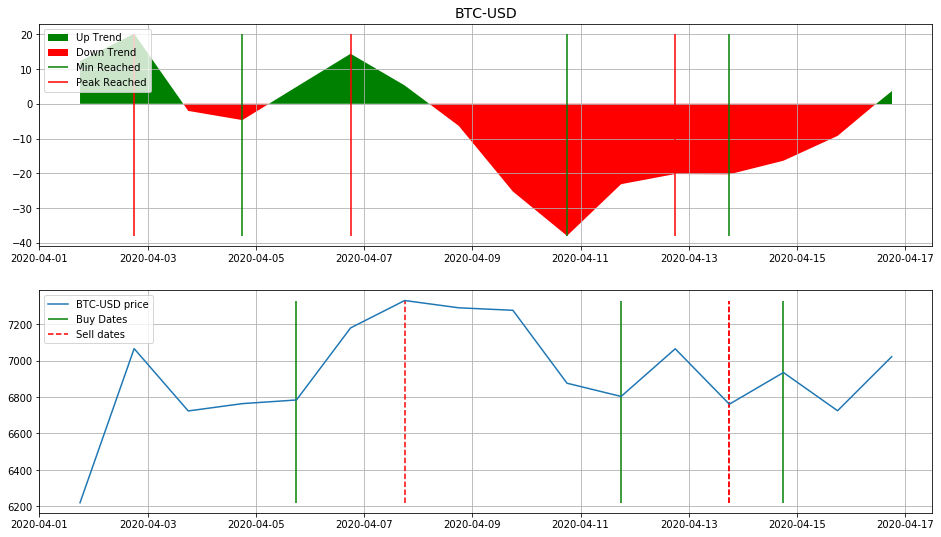

In [12]:
plotting.plot_model(model, plot_range=plot_range)

In [13]:
imag_model = model.copy_model()

In [14]:
imag_model.append_timedelta(timedelta=1)

[USER-INPUT]: Overwrite existing data? [y/n]: y
[INFO]: NaN values were append.


In [15]:
imag_model.data

,BTC-USD
2020-01-01 18:00:00+00:00,7238.930664
2020-01-02 18:00:00+00:00,6999.171387
2020-01-03 18:00:00+00:00,7373.281250
2020-01-04 18:00:00+00:00,7354.490234
2020-01-05 18:00:00+00:00,7536.349121
...,...
2020-04-13 18:00:00+01:00,6760.631836
2020-04-14 18:00:00+01:00,6934.579102
2020-04-15 18:00:00+01:00,6724.846191
2020-04-16 18:00:00+01:00,7021.342285


In [16]:
imag_model.comp_break_values(['BTC-USD', 'LTC-USD'])

[WARNING]: Ticker "LTC-USD" not in available tickers
[INFO]: Compute break values with 30.00% deviation
[USER INPUT]: Append breaking values w.r.t smallest tolerances? n
[INFO]: Current values: {'BTC-USD': 7021.34228515625}
[INFO]: Break values: {'BTC-USD': [7067.68314423839, 6659.0410232422755]}
[INFO]: Tolerances: {'BTC-USD': array([  46.34085908, -362.30126191])}


In [17]:
imag_model.eval_model(tickers=['BTC-USD', 'LTC-USD'])

[WARNING]: Ticker "LTC-USD" not in available tickers
|                                  PRICE MODEL                                   |
|                                  Version 0.3                                   |
|                   Authors: Marco Rosenzweig & Patrick Lorenz                   |
----------------------------------------------------------------------------------
|                              ticker = ['BTC-USD']                              |
|                             start date = 01/01/20                              |
|                              end date = 04/17/20                               |
|                      initial investment per ticker = 200                       |
[TICKER]: BTC-USD
[INFO]: Open position.
[INFO]: No tax paid.
[INFO]: Last entry of "Sell Dates" will be assigned equally as the penultimate one.
----------------------------------------------------------------------------------
[SUMMARY]: Average trade win: 5.9076326835%
[SUMMARY]:

In [18]:
imag_model.ticker_df['BTC-USD']

,Buy Dates,Sell Dates,Buy Prices,Sell Prices,Trade Reward,Trade Win,Trade Efficiency
0,2020-01-10 18:00:00,2020-01-11 18:00:00,8056.407841,8092.316211,200.891424,0.891424,0.004457
1,2020-01-13 18:00:00,2020-01-15 18:00:00,8159.626720,8710.168962,214.445869,13.554445,0.067471
2,2020-01-20 18:00:00,2020-01-22 18:00:00,8703.297439,8635.120274,212.766010,-1.679859,-0.007833
3,2020-01-23 18:00:00,2020-01-30 18:00:00,8372.618587,9450.361622,240.153749,27.387738,0.128722
4,2020-02-04 18:00:00,2020-02-06 18:00:00,9215.028143,9684.722914,252.394510,12.240761,0.050971
5,2020-02-08 18:00:00,2020-02-09 18:00:00,9854.609010,10013.333228,256.459727,4.065217,0.016107
6,2020-02-11 18:00:00,2020-02-12 18:00:00,10167.854639,10278.565529,259.252143,2.792416,0.010888
7,2020-02-16 18:00:00,2020-02-19 18:00:00,9843.817061,10121.483827,266.564927,7.312784,0.028207
8,2020-02-21 18:00:00,2020-02-23 18:00:00,9737.208008,9833.696578,269.206389,2.641462,0.009909
9,2020-02-26 18:00:00,2020-03-03 18:00:00,8823.553376,8684.136919,264.952796,-4.253593,-0.015800


In [28]:
for ticker in imag_model.tickers:
    print('Current ticker: {}'.format(ticker))
    print('Last 2 values in data set: {}'.format(imag_model.data[ticker].values[-2:]))
    print('Break values: {}'.format(imag_model.break_values[ticker]))
    print('Tolerances: {}'.format(imag_model.tolerances[ticker]))
    print('#' * 10)

Current ticker: BTC-USD
Last 2 values in data set: [7021.34228516           nan]
Break values: [7067.68314423839, 6659.0410232422755]
Tolerances: [  46.34085908 -362.30126191]
##########


In [29]:
imag_model._init_model()
imag_model.data.tail(1)

[INIT]: Initialising model for tickers: ['BTC-USD']
[INIT]: Successfully initialized model.
**********************************************************************************


,BTC-USD
2020-04-17 18:00:00+01:00,NaN


In [30]:
start = imag_model.data['BTC-USD'].index.get_loc(plot_range[0])
imag_plot_range = imag_model.data.index[start:]

[INFO]: New sell signal was detected for last value: nan.


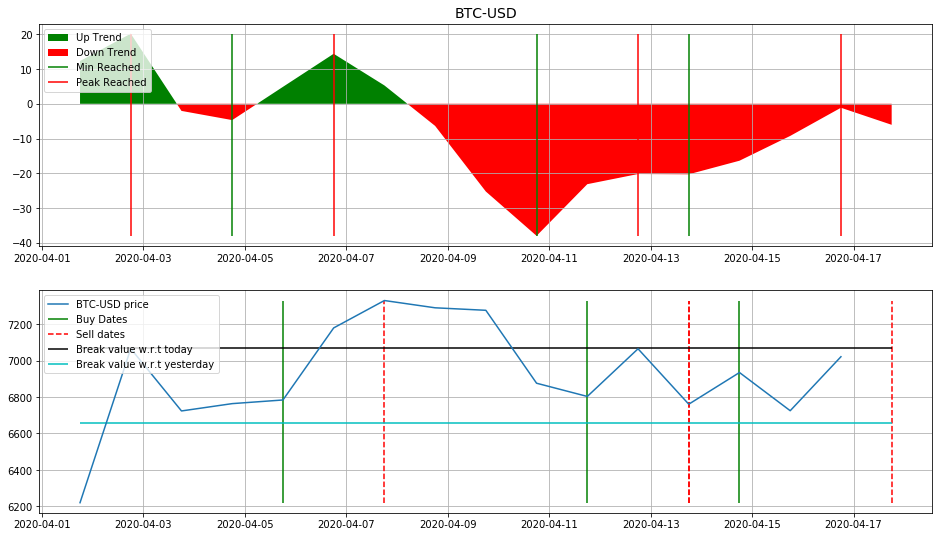

In [31]:
ax1, ax2 = plotting.plot_model(imag_model, plot_range=imag_plot_range)

[INFO]: Current ticker: BTC-USD
----------------------------------------------------------------------------------
[INFO]: New sell signal was detected for last value: 6326.0889720801615.
----------------------------------------------------------------------------------
[INFO]: New sell signal was detected for last value: 6863.362083740332.
----------------------------------------------------------------------------------


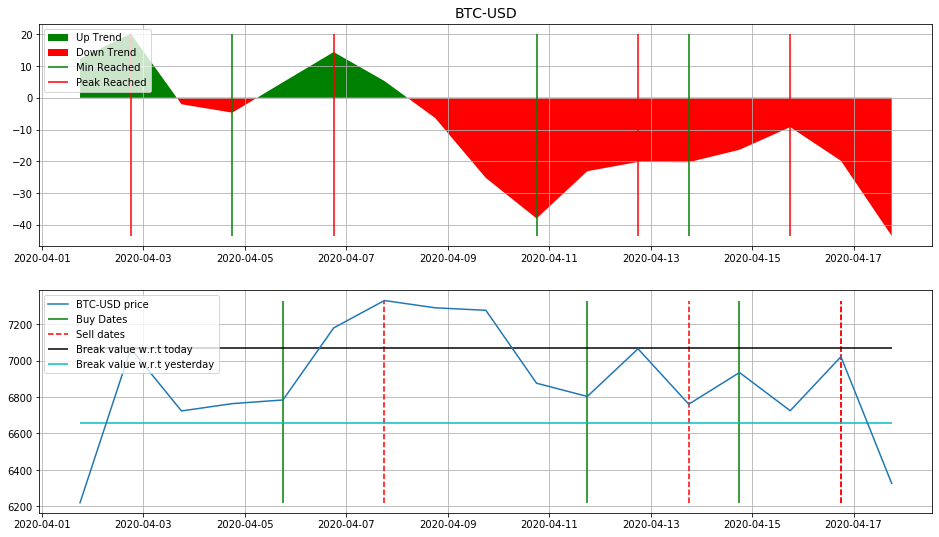

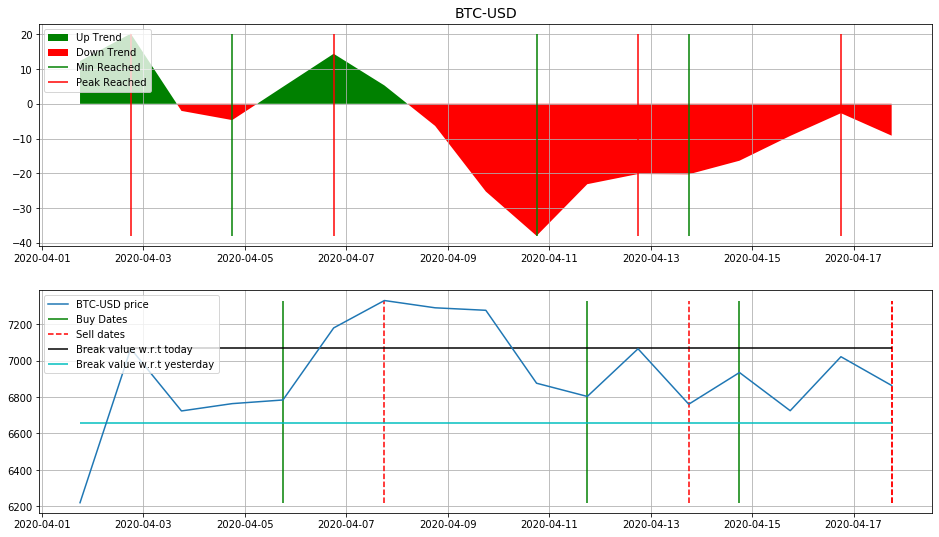

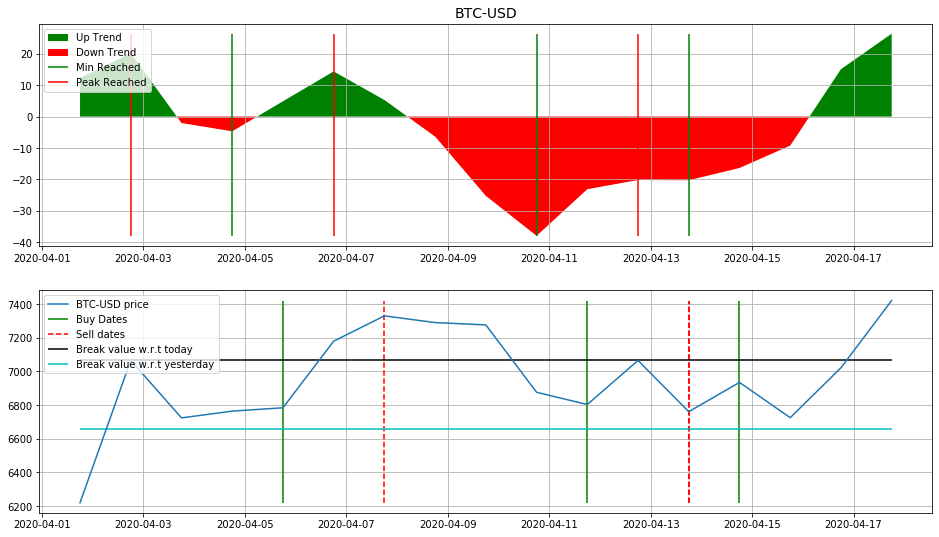

In [32]:
imag_model.show_possibilities(plot_range=imag_plot_range)

In [66]:
stats_data = utils.download_data(tickers='BTC-USD', start='2019-01-01', interval='60m')

[*********************100%***********************]  1 of 1 completed


In [69]:
statistics.comp_z_values(model=imag_model, stats_data=stats_data)

46.340859082140014
-362.3012619139745
